# Step1 : Import Libraries

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import scipy

# Step2 : Define Constants

In [2]:
fast_run = False
Size = 120
image_size = (Size,Size)
image_channel = 3

# Step3 : Prepare Traning Data

In [3]:
filenames = os.listdir('train')
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
    })

In [4]:
df.head()

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0

In [5]:
df['category'].value_counts()

category
0    12500
1    12500
Name: count, dtype: int64

In [6]:
df.tail()

filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

See Total In count

<Axes: xlabel='category'>

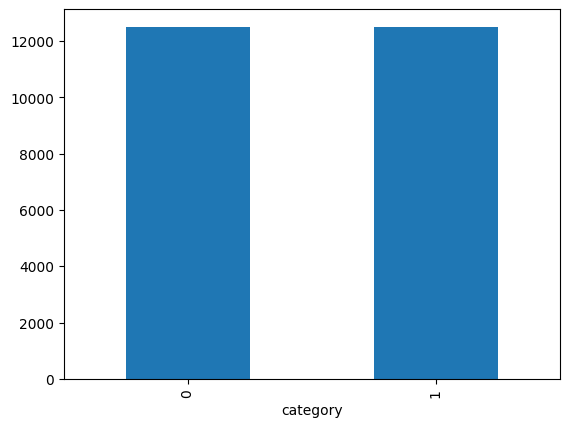

In [7]:
df['category'].value_counts().plot.bar()

See sample image

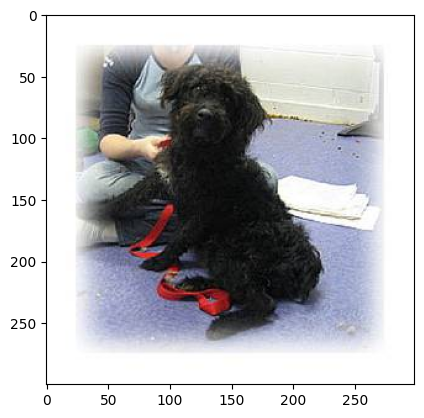

In [8]:
sample = random.choice(filenames)
image = load_img("train/" + sample)
plt.imshow(image)

# Step4 : Bulid Model

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(Size, Size, image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 118, 118, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 59, 59, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 57, 57, 64)       2

Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [11]:
earlystop = EarlyStopping(patience=10)

Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

# Step5 : Prepare data
Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

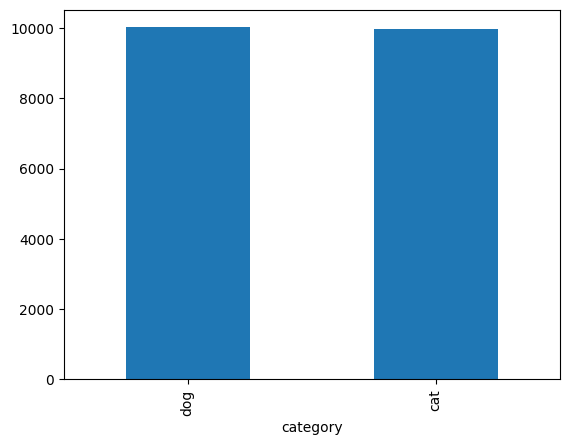

In [16]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

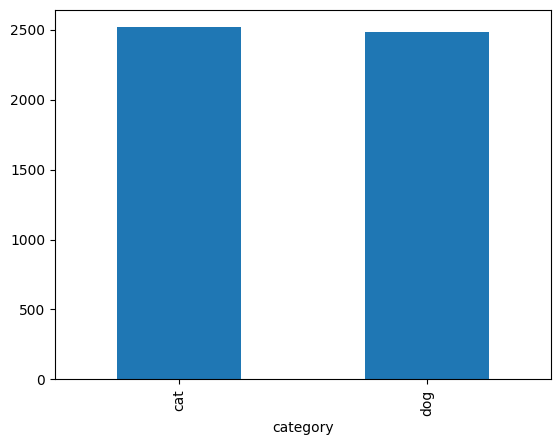

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=64

Traning Generator

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


Validation Generator

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


See how our generator work

In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


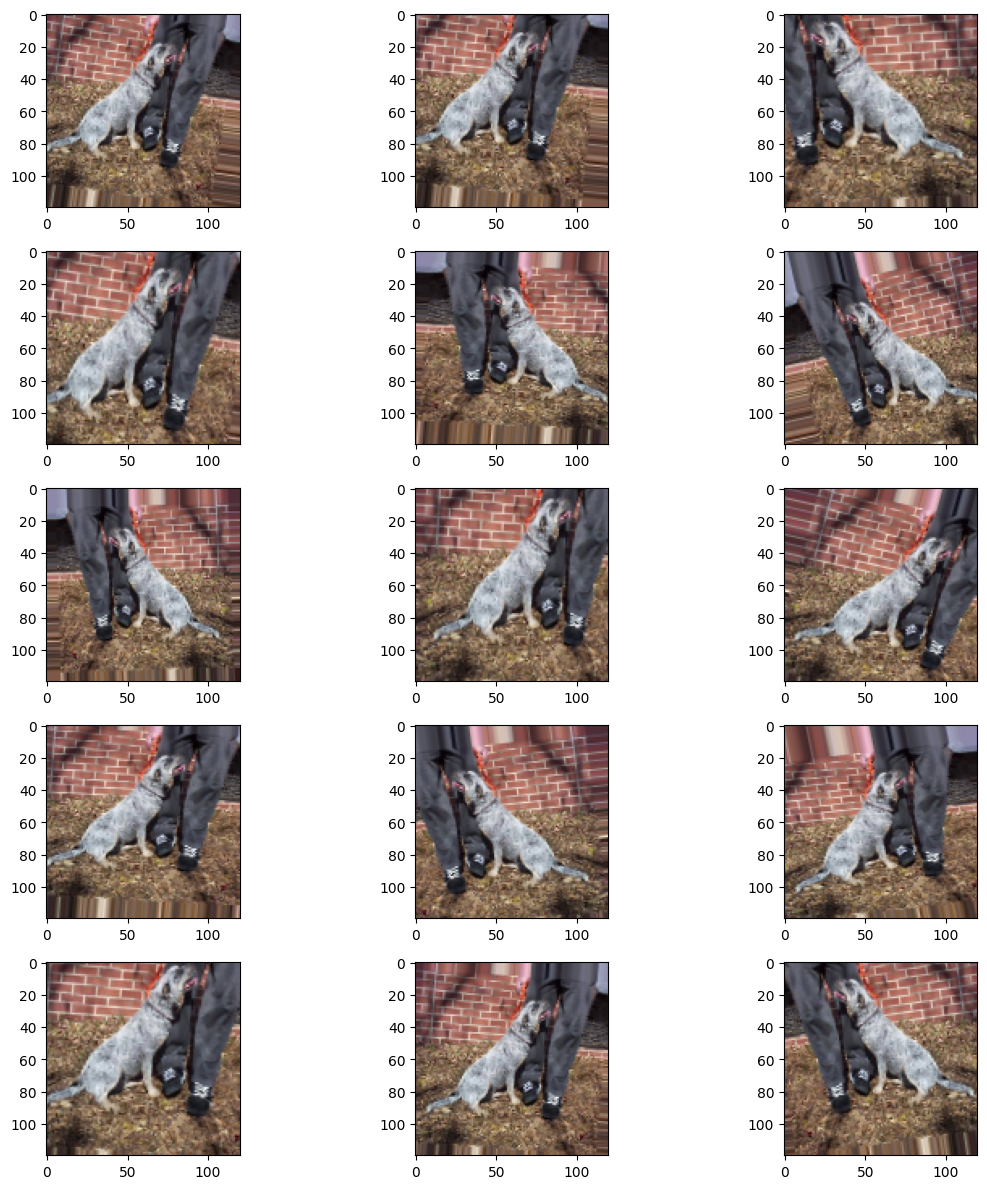

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Step6 : Fit Model

In [23]:
epochs=3 if fast_run else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
312/312 [==============================] - 85s 258ms/step - loss: 0.8091 - accuracy: 0.6361 - val_loss: 0.9213 - val_accuracy: 0.5264 - lr: 0.0010
Epoch 2/50
312/312 [==============================] - 80s 256ms/step - loss: 0.5542 - accuracy: 0.7219 - val_loss: 0.7906 - val_accuracy: 0.5853 - lr: 0.0010
Epoch 3/50
312/312 [==============================] - 82s 262ms/step - loss: 0.4722 - accuracy: 0.7773 - val_loss: 0.4981 - val_accuracy: 0.7945 - lr: 0.0010
Epoch 4/50
312/312 [==============================] - 82s 262ms/step - loss: 0.4330 - accuracy: 0.8022 - val_loss: 0.3711 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 5/50
312/312 [==============================] - 82s 262ms/step - loss: 0.3992 - accuracy: 0.8184 - val_loss: 0.3811 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 6/50
312/312 [==============================] - 81s 259ms/step - loss: 0.3815 - accuracy: 0.8286 - val_loss: 0.4253 - val_accuracy: 0.8305 - lr: 0.0010
Epoch 7/50
312/312 [==============================] 

Save Model

In [24]:
model.save("model.h5")

Virtualize Training

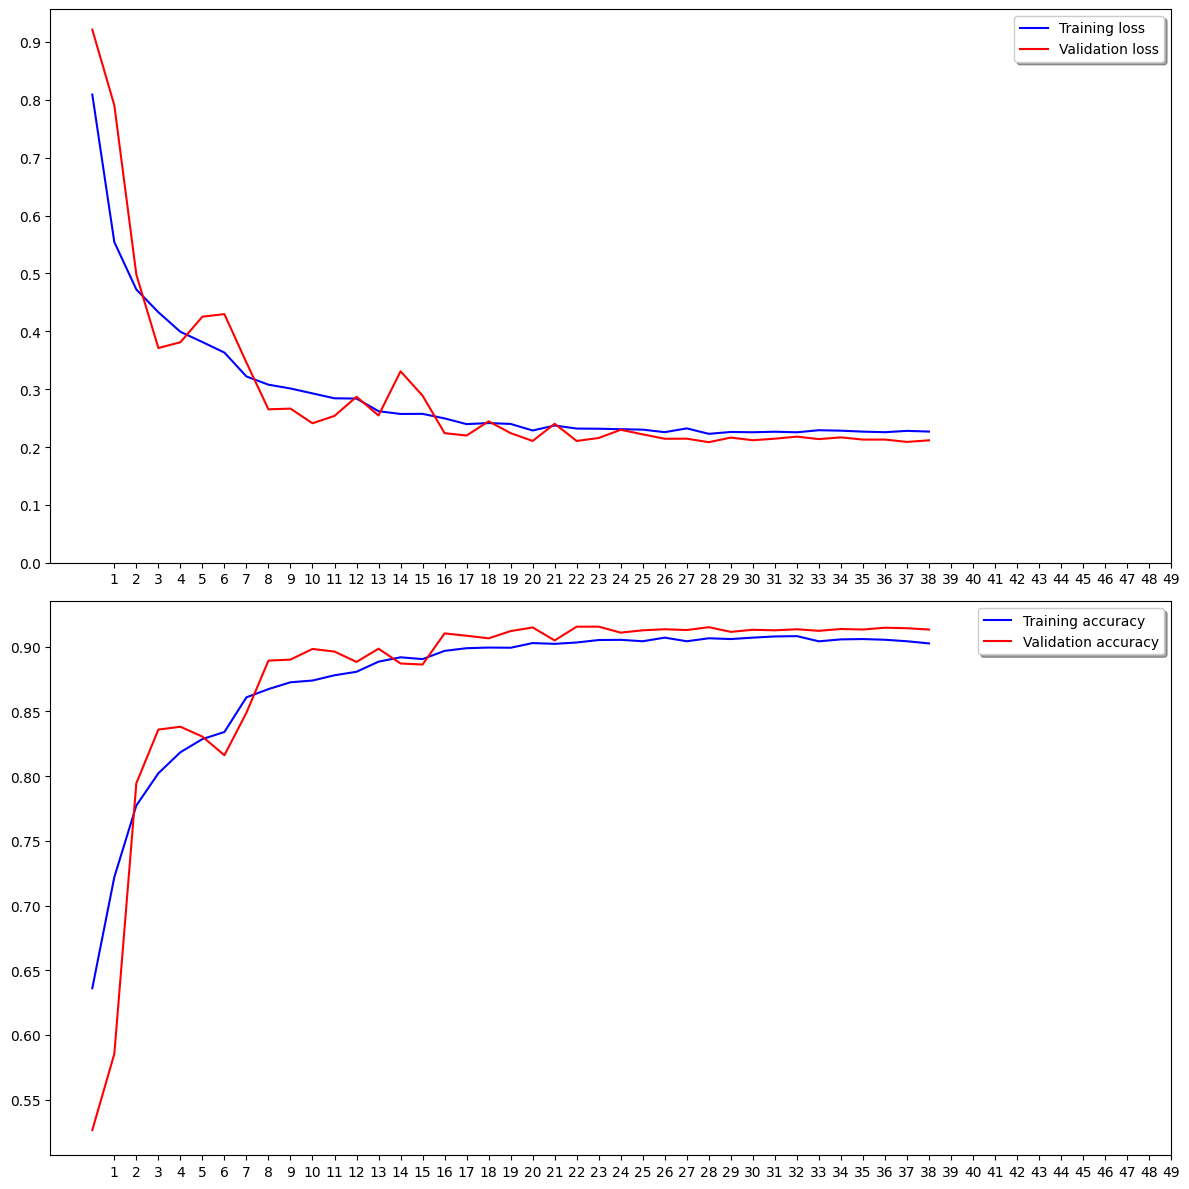

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True) 

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend(loc='best', shadow=True)  

plt.tight_layout()
plt.show()

# Step7 : Prepare Testing Data

In [29]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

Create Testing Generator


In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


Predict

In [32]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

196/196 [==============================] - 61s 310ms/step


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [33]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [34]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [35]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

C:\Users\DELL G5\AppData\Local\Temp\ipykernel_15952\163432756.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })


Virtaulize Result


<Axes: xlabel='category'>

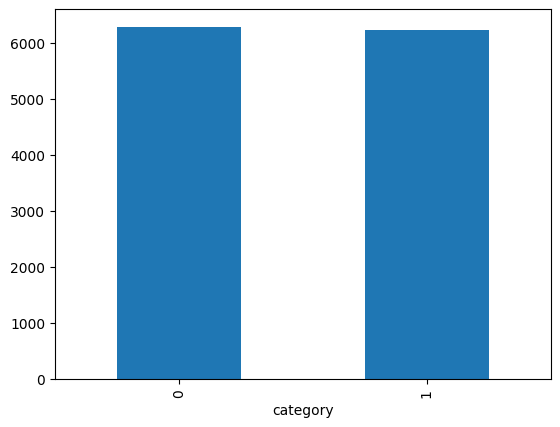

In [36]:
test_df['category'].value_counts().plot.bar()

See predicted result with images


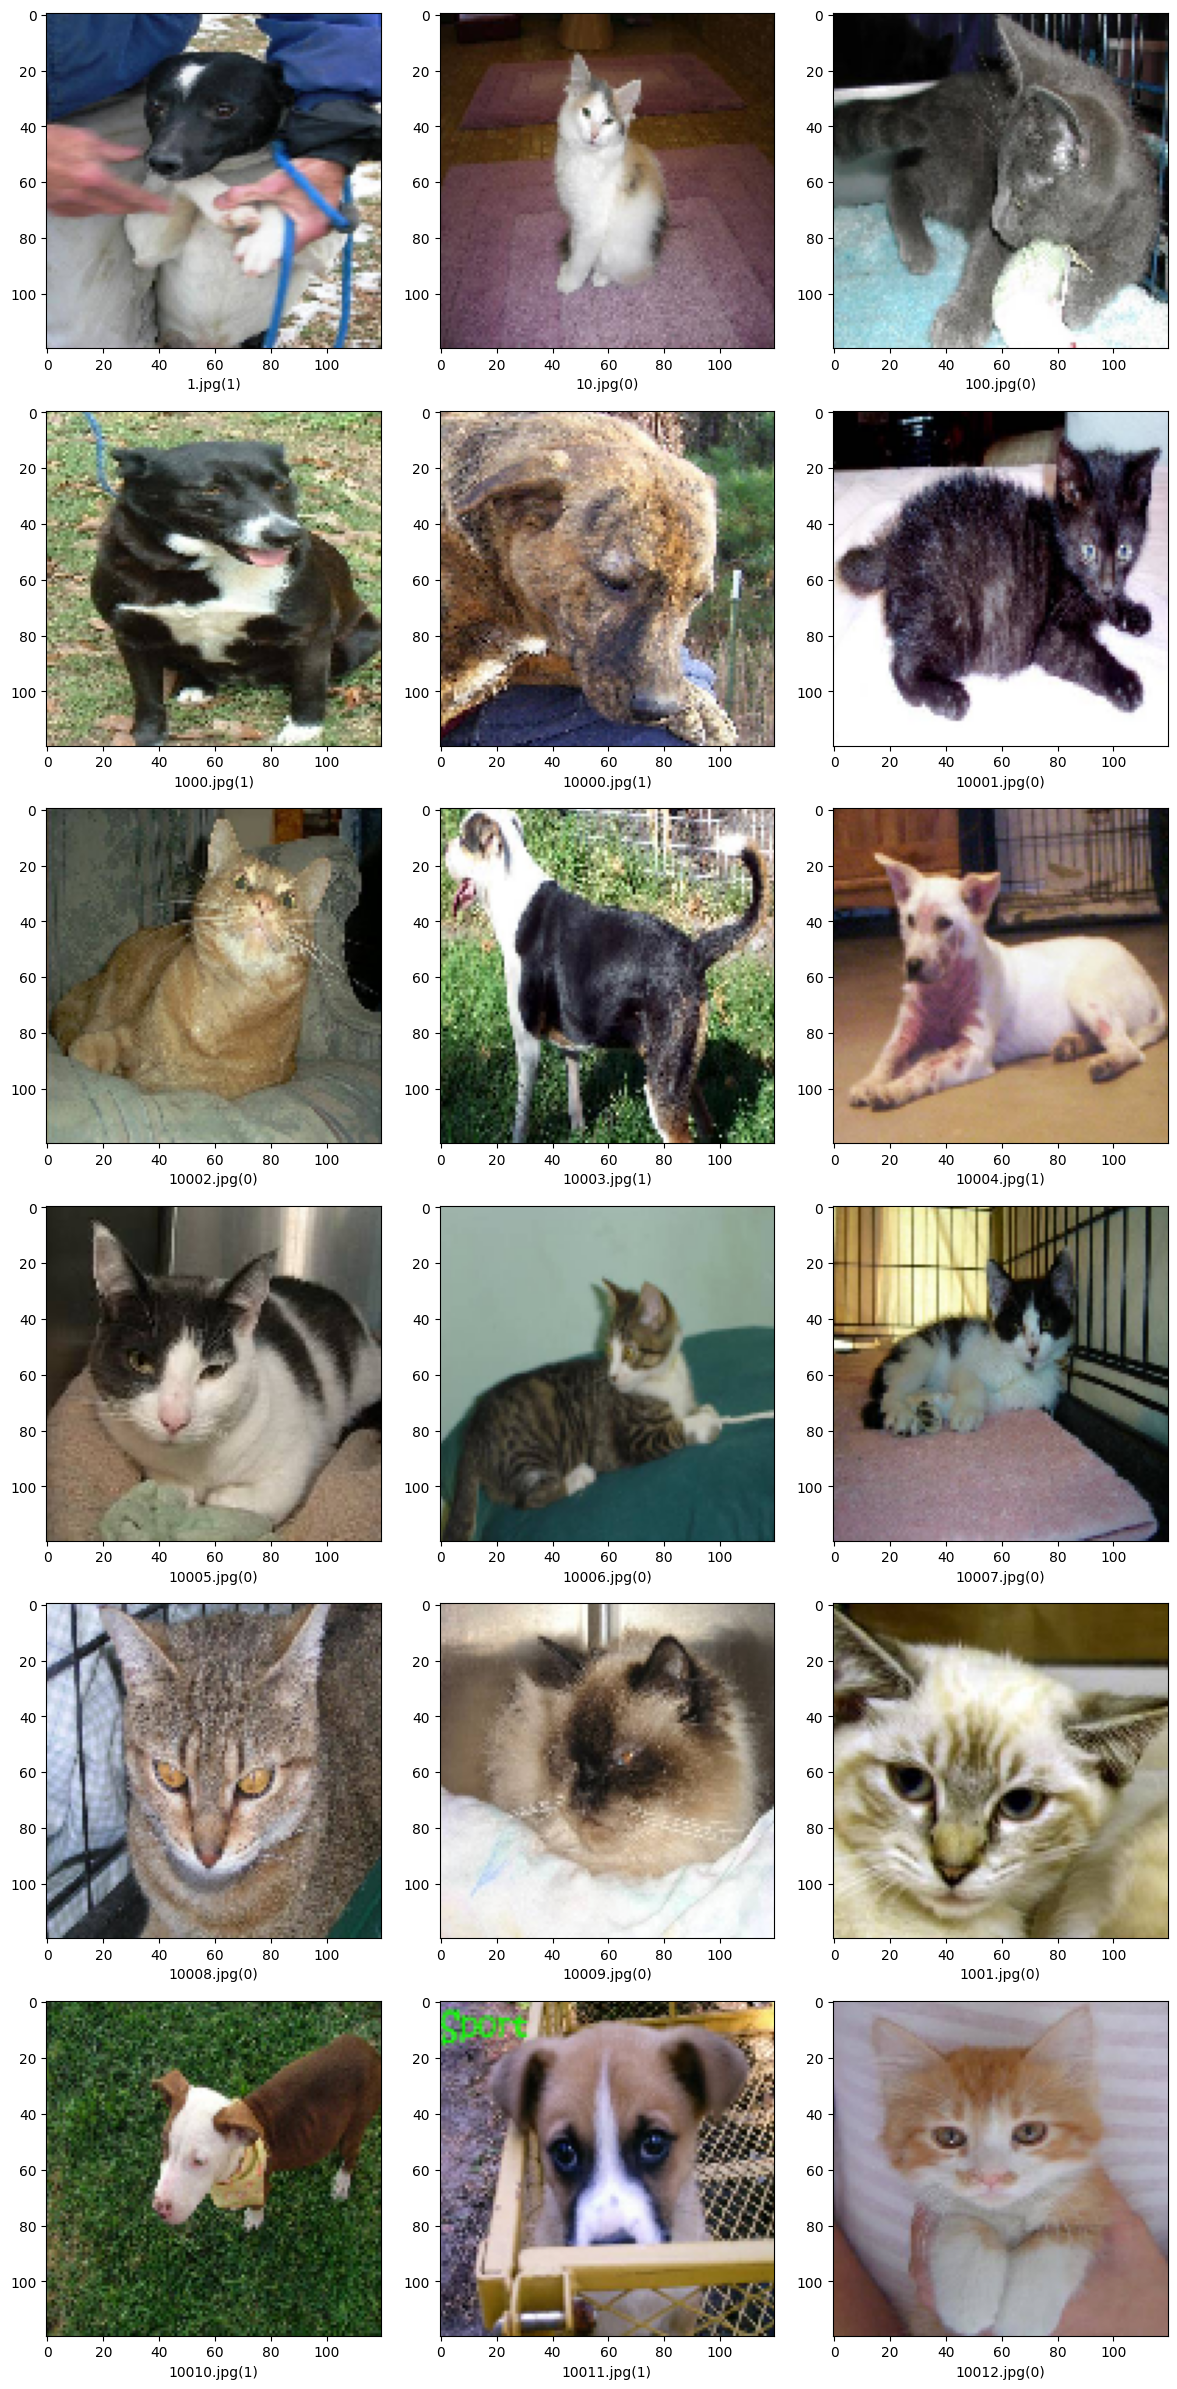

In [37]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=image_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()